Walk trees part 2: walks and selections
----------
- Author: [Timothy Hobbs](https://timothy.hobbs.cz)
- License: [CC-BY-NC 4.0](https://creativecommons.org/licenses/by-nc/4.0/)
- Written: 1.2020
- Send PRs to: [github](https://github.com/timthelion/rust-jupyter)

[project homepage](https://github.com/timthelion/petgraph-fsm) [ipynb](./walk-trees-part2-walks.ipynb)

Walk trees are a novel algorithm for selecting regions of graphs.

A walk is a connected subgraph of a graph. It is selected by selecting an alternating sequence of vertex's and edges. 


In [2]:
:dep petgraph-examples = {path="./petgraph-examples"}

In [3]:
:dep petgraph-evcxr = {path="./petgraph-evcxr"}

In [4]:
:dep petgraph-fsm = {path="./petgraph-fsm"}

In [5]:
:dep petgraph = {path="./petgraph"}

In [6]:
use std::collections::HashMap;
use petgraph::*;
use petgraph::data::*;
use petgraph::visit::*;
use petgraph::graph::*;
use petgraph::dot::*;
use petgraph_evcxr::*;
use std::hash::Hash;

In [7]:
pub struct Overlay<'a, G, E, N, EW, NW, ER, A>
where
    &'a G: GraphBase<EdgeId = E, NodeId = N> + Data<EdgeWeight = EW, NodeWeight = NW>,
    ER: EdgeRef<Weight = EW, EdgeId = E, NodeId = N>,
    E: Copy + Eq + Hash,
    N: Copy + Eq + Hash,
{
    nodes: HashMap<N, A>,
    edges: HashMap<E, A>,
    edge_refs: HashMap<E, ER>,
    graph: &'a G,
}

In [8]:
pub type Selection<'a, G, E, N, EW, NW, ER> = Overlay<'a, G, E, N, EW, NW, ER, ()>;

In [9]:
#[derive(Debug, Clone)]
enum Phase<'a, N, E> {
    Nodes(std::collections::hash_map::Iter<'a, N, ()>),
    Edges(std::collections::hash_map::Iter<'a, E, ()>),
}

pub struct SelectedItems<'a, G, E, N, EW, NW, ER>
where
    &'a G: GraphBase<EdgeId = E, NodeId = N> + Data<EdgeWeight = EW, NodeWeight = NW> + DataMap,
    ER: EdgeRef<Weight = EW, EdgeId = E, NodeId = N>,
    E: Copy + Eq + Hash,
    N: Copy + Eq + Hash,
{
    selection: &'a Selection<'a, G, E, N, EW, NW, ER>,
    phase: Phase<'a, N, E>,
    node_indexes: HashMap<N, usize>,
}

In [21]:
impl<'a, G, E, N, EW, NW, ER> Selection<'a, G, E, N, EW, NW, ER>
where
    &'a G: GraphBase<EdgeId = E, NodeId = N> + Data<EdgeWeight = EW, NodeWeight = NW> + DataMap,
    ER: EdgeRef<Weight = EW, EdgeId = E, NodeId = N>,
    E: Copy + Eq + Hash,
    N: Copy + Eq + Hash,
{
    fn to_elements(&'a self) -> SelectedItems<'a, G, E, N, EW, NW, ER>{
        SelectedItems{
            selection: self,
            phase: Phase::Nodes(self.nodes.iter()),
            node_indexes: HashMap::new(),
        }
    }
}

In [10]:
impl<'a, G, E, N, EW, NW, ER> Iterator for SelectedItems<'a, G, E, N, EW, NW, ER>
where
    &'a G: GraphBase<EdgeId = E, NodeId = N> +
           Data<EdgeWeight = EW, NodeWeight = NW> +
           DataMap,
    NW: Clone,
    EW: Clone,
    ER: EdgeRef<Weight = EW, EdgeId = E, NodeId = N>,
    E: Copy + Eq + Hash,
    N: Copy + Eq + Hash,
{
    type Item = Element<NW, EW>;
    
    fn next(&mut self) -> Option<Self::Item> {
        if let Phase::Nodes(ref mut nodes) = self.phase {
            match nodes.next() {
                Some(node) =>  {
                    self.node_indexes.insert(*node.0, self.node_indexes.len());
                    return Some(Element::Node {
                        weight: self.selection.graph.node_weight(*node.0).unwrap().clone()
                    })
                },
                None => self.phase = Phase::Edges(self.selection.edges.iter()),
            }
        };
        if let Phase::Edges(ref mut edges) = self.phase.clone() {
            loop{
                let edge_ref_maybe = edges.next()
                    .and_then(|edge| self.selection.edge_refs.get(edge.0));
                match edge_ref_maybe {
                    Some(edge_ref) => {
                        let new_edge_maybe = self.node_indexes.get(&edge_ref.source())
                            .and_then(|source| self.node_indexes.get(&edge_ref.target())
                                .map(|target| Element::Edge {
                                        weight: edge_ref.weight().clone(),
                                        source: *source,
                                        target: *target,
                                }
                            ));
                        match new_edge_maybe {
                            Some(new_edge) => {
                                self.phase = Phase::Edges(edges.clone());
                                return Some(new_edge);
                            },
                            None => continue
                        }
                    },
                    None => {
                        self.phase = Phase::Edges(edges.clone());
                        return None;
                    }
                }
            }
        };
        None
    }
}

In [11]:
impl<'a, G, E, N, EW, NW, ER> Selection<'a, G, E, N, EW, NW, ER>
where
    &'a G: GraphBase<EdgeId = E, NodeId = N> +
       Data<EdgeWeight = EW, NodeWeight=NW> +
       GraphProp +
       NodeIndexable + 
       IntoNodeReferences +
       IntoEdgeReferences,
    ER: EdgeRef<Weight = EW, EdgeId = E, NodeId = N>,
    E: Copy + Eq + Hash,
    N: Copy + Eq + Hash,
    NW: std::fmt::Display,
    EW: std::fmt::Display,
{
    pub fn new(g: &'a G) -> Selection<'a, G, E, N, EW, NW, ER> {
        Selection{
            nodes: HashMap::new(),
            edges: HashMap::new(),
            edge_refs: HashMap::new(),
            graph: g,
        }
    }
    
    pub fn draw_selection<'b>(&'b self) {
        draw_graph_with_attr_getters(
                self.graph,
                &[],
                &|_, er| format!("color = {}", if self.edges.contains_key(&er.id()) { "red" } else { "black" }),
                &|_, nr| format!("color = {}", if self.nodes.contains_key(&nr.id()) { "red" } else { "black" }),
        );
    }
    pub fn select_edge<'b>(&'b mut self, edge: ER) {
        self.edges.insert(edge.id(), ());
        self.edge_refs.insert(edge.id(), edge);
    }
    pub fn select_node<'b>(&'b mut self, node: N) {
        self.nodes.insert(node, ());
    }
    pub fn deselect_edge<'b>(&'b mut self, edge: E) {
        self.edges.remove(&edge);
    }
    fn deselect_node<'b>(&'b mut self, node: N) {
        self.nodes.remove(&node);
    }
}

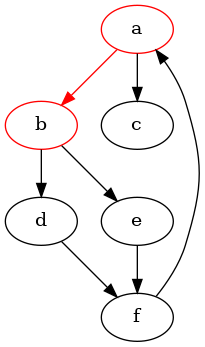

In [17]:
use petgraph_examples as examples;
use petgraph::visit::IntoNodeReferences;
extern crate petgraph;
let dwc = examples::directed_graph_with_cycle();
fn ex1<'a>(dwc: &'a Graph<String, String, petgraph::Directed>){

    let mut selection: Selection<'a, Graph<String, String, petgraph::Directed>, EdgeIndex, NodeIndex, String, String, EdgeReference<String>> = Selection::new(&dwc);
    selection.select_node(node_index(0));
    selection.select_edge(dwc.edge_references().next().unwrap());
    selection.select_node(node_index(1));
    selection.draw_selection();
}
ex1(&dwc);

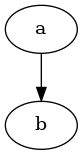

In [27]:
fn ex2<'a>(dwc: &'a Graph<String, String, petgraph::Directed>){

    let mut selection: Selection<'a, Graph<String, String, petgraph::Directed>, EdgeIndex, NodeIndex, String, String, EdgeReference<String>> = Selection::new(&dwc);
    selection.select_node(node_index(0));
    selection.select_edge(dwc.edge_references().next().unwrap());
    selection.select_node(node_index(1));
    let extracted_selection: Graph<String, String, petgraph::Directed> = Graph::from_elements(selection.to_elements());
    draw_graph(&extracted_selection);
}
ex2(&dwc);